In [1]:
import numpy as np
import tensorflow as tf
import time
import random
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt

C:\Users\kwea123\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Episode_experience():
    def __init__(self):
        self.memory = []
        
    def add(self, state, action, reward, next_state, done, goal):
        self.memory += [(state, action, reward, next_state, done, goal)]
        
    def clear(self):
        self.memory = []

class DDPGAgent:
    def __init__(self, state_size, action_size, goal_size, action_low=-1, action_high=1, gamma=0.98,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, tau=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.goal_size = goal_size
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = gamma   # discount rate
        self.memory = []
        self.buffer_size = int(5e4)
        self.a_learning_rate = actor_learning_rate
        self.c_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.tau = tau # soft update
        self.batch_size = 32
        self.gradient_norm_clip = None
        self._construct_nets()
        
    def _construct_nets(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        
        self.S = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.S_ = tf.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.G = tf.placeholder(tf.float32, [None, self.goal_size], 'goal')
        self.D = tf.placeholder(tf.float32, [None, 1], 'done')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, self.G, scope='eval')
            self.a_ = self._build_a(self.S_, self.G, scope='target')
        with tf.variable_scope('Critic'):
            self.q = self._build_c(self.S, self.a, self.G, scope='eval')
            self.q_ = self._build_c(self.S_, self.a_, self.G, scope='target')
        
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        self.soft_update_op = [[tf.assign(ta, (1 - self.tau) * ta + self.tau * ea), tf.assign(tc, (1 - self.tau) * tc + self.tau * ec)]
                             for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]
        
        q_target = self.R + self.gamma * (1-self.D) * self.q_
#         q_target = tf.clip_by_value(q_target, -1/(1-self.gamma), 0)
        
        self.c_loss = tf.losses.mean_squared_error(q_target, self.q)
        self.a_loss = - tf.reduce_mean(self.q)    # maximize the q
        
        if self.gradient_norm_clip is not None:
            c_optimizer = tf.train.AdamOptimizer(self.c_learning_rate)
            c_gradients = c_optimizer.compute_gradients(self.c_loss, var_list=self.ce_params)
            for i, (grad, var) in enumerate(c_gradients):
                if grad is not None:
                    c_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.c_train = c_optimizer.apply_gradients(c_gradients)
            a_optimizer = tf.train.AdamOptimizer(self.a_learning_rate)
            a_gradients = c_optimizer.compute_gradients(self.a_loss, var_list=self.ae_params)
            for i, (grad, var) in enumerate(a_gradients):
                if grad is not None:
                    a_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.a_train = a_optimizer.apply_gradients(a_gradients)
        else:
            self.c_train = tf.train.AdamOptimizer(self.c_learning_rate).minimize(self.c_loss, var_list=self.ce_params)
            self.a_train = tf.train.AdamOptimizer(self.a_learning_rate).minimize(self.a_loss, var_list=self.ae_params)
            
        self.saver = tf.train.Saver()
        
        self.sess.run(tf.global_variables_initializer())
    
    def _build_a(self, s, g, scope): # policy
        with tf.variable_scope(scope):
            net = tf.concat([s, g], 1)
            net = tf.layers.dense(net, 64, tf.nn.relu)
            net = tf.layers.dense(net, 64, tf.nn.relu)
            net = tf.layers.dense(net, 64, tf.nn.relu)
            a = tf.layers.dense(net, self.action_size, tf.nn.tanh)
            return a * (self.action_high-self.action_low)/2 + (self.action_high+self.action_low)/2
    
    def _build_c(self, s, a, g, scope): # Q value
        with tf.variable_scope(scope):
            net = tf.concat([s, a, g], 1)
            net = tf.layers.dense(net, 64, tf.nn.relu)
            net = tf.layers.dense(net, 64, tf.nn.relu)
            net = tf.layers.dense(net, 64, tf.nn.relu)
            return tf.layers.dense(net, 1)
    
    def choose_action(self, state, goal, variance): # normal distribution
        action = self.sess.run(self.a, {self.S: state, self.G: goal})[0]
        return np.clip(np.random.normal(action, variance), self.action_low, self.action_high)
    
    def remember(self, ep_experience):
        self.memory += ep_experience.memory
        if len(self.memory) > self.buffer_size:
            self.memory = self.memory[-self.buffer_size:] # empty the first memories
        
    def replay(self, optimization_steps=1):
        if len(self.memory) < self.batch_size: # if there's no enough transitions, do nothing
            return 0, 0
        
        a_losses = 0
        c_losses = 0
        for _ in range(optimization_steps):
            minibatch = np.vstack(random.sample(self.memory, self.batch_size))
            ss = np.vstack(minibatch[:,0])
            acs = np.vstack(minibatch[:,1])
            rs = np.vstack(minibatch[:,2])
            nss = np.vstack(minibatch[:,3])
            ds = np.vstack(minibatch[:,4])
            gs = np.vstack(minibatch[:,5])
            a_loss, _ = self.sess.run([self.a_loss, self.a_train],
                                      {self.S: ss, self.G: gs})
            c_loss, _ = self.sess.run([self.c_loss, self.c_train],
                                      {self.S: ss, self.a: acs, self.R: rs,
                                       self.S_: nss, self.D: ds, self.G: gs})
            a_losses += a_loss
            c_losses += c_loss
            
        return a_losses/optimization_steps, c_losses/optimization_steps
    
    def update_target_net(self):
        self.sess.run(self.soft_update_op)

In [3]:
env_name = "robot_arm_3d_her_sparse"
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

# Reset the environment
env_info = env.reset(train_mode=False)[default_brain]
    
# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.states[0]))

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 15
        Action space type: continuous
        Action space size (per agent): 4
        Memory space size (per agent): 0
        Action descriptions: , , , 
Agent state looks like: 
[-0.03149452 -0.8156048   0.49921322  0.         -1.          0.
  0.         -1.78        0.          0.          0.          0.
  0.          0.          0.        ]


In [4]:
def reward_func(state, goal):
    hand = state[3:6]
    dist = np.linalg.norm(hand-goal)*5 # range=5
    done = False
    reward = -1
    if dist<=1:
        done = True
        reward = 1
    return done, reward

# DDPG agent

In [5]:
agent = DDPGAgent(state_size=12, action_size=4, goal_size=3, action_high=1,
                  action_low=-1, actor_learning_rate=1e-3, critic_learning_rate=1e-3,
                  tau=0.1
                 )
variance=5

## With HER

In [6]:
use_her = True # use hindsight experience replay or not
num_epochs = 100
num_episodes = 20 # number of episodes over which success rate is computed
episode_length = 500
optimization_steps = 40
K = 8 # number of random future states

a_losses = []
c_losses = []
ep_mean_r = []
success_rate = []

ep_experience = Episode_experience()
ep_experience_her = Episode_experience()

start = time.clock()
total_step = 0
for i in range(num_epochs):
    successes = 0
    ep_total_r = 0
    for n in range(num_episodes):
        env_info = env.reset(train_mode=True)[default_brain]
        state = env_info.states[0][3:]
        goal = env_info.states[0][:3]
        for ep_step in range(episode_length):
            total_step += 1
            action = agent.choose_action([state], [goal], variance)
            env_info = env.step(action)[default_brain]
            next_state = env_info.states[0][3:]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            ep_total_r += reward
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if total_step % 200 == 0 or done:
                if use_her: # The strategy can be changed here
                    for t in range(len(ep_experience.memory)):
                        for _ in range(K):
                            future = np.random.randint(t, len(ep_experience.memory))
                            goal_ = ep_experience.memory[future][3][3:6] # next_state of future
                            state_ = ep_experience.memory[t][0]
                            action_ = ep_experience.memory[t][1]
                            next_state_ = ep_experience.memory[t][3]
                            done_, reward_ = reward_func(next_state_, goal_)
                            ep_experience_her.add(state_, action_, reward_, next_state_, done_, goal_)
                    agent.remember(ep_experience_her)
                    ep_experience_her.clear()
                agent.remember(ep_experience)
                ep_experience.clear()
                variance *= 0.9995
                a_loss, c_loss = agent.replay(optimization_steps)
                a_losses += [a_loss]
                c_losses += [c_loss]
                agent.update_target_net()
            if done:
                break
        successes += reward>=0 and done

    success_rate.append(successes/num_episodes)
    ep_mean_r.append(ep_total_r/num_episodes)
    print("\repoch", i+1, "success rate %.2f"%success_rate[-1], "ep_mean_r %.2f"%ep_mean_r[-1], 'exploration %.2f'%variance, end=' '*10)

print("Training time : %.2f"%(time.clock()-start), "s")

epoch 100 success rate 1.00 ep_mean_r -50.85 exploration 0.82          Training time : 1165.94 s


In [7]:
agent.saver.save(agent.sess, "model/model3d_range5_ddpg_her_sparse.ckpt");

## Without HER

In [16]:
agent = DDPGAgent(state_size=12, action_size=4, goal_size=3, action_high=1,
                  action_low=-1, actor_learning_rate=1e-3, critic_learning_rate=1e-3,
                  tau=0.1
                 )
variance=5

In [17]:
num_epochs = 100
num_episodes = 20 # number of episodes over which success rate is computed
episode_length = 500
optimization_steps = 40

a_losses_without_her = []
c_losses_without_her = []
ep_mean_r_without_her = []
success_rate_without_her = []

ep_experience = Episode_experience()

start = time.clock()
total_step = 0
for i in range(num_epochs):
    successes = 0
    ep_total_r = 0
    for n in range(num_episodes):
        env_info = env.reset(train_mode=True)[default_brain]
        state = env_info.states[0][3:]
        goal = env_info.states[0][:3]
        for ep_step in range(episode_length):
            total_step += 1
            action = agent.choose_action([state], [goal], variance)
            env_info = env.step(action)[default_brain]
            next_state = env_info.states[0][3:]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            ep_total_r += reward
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if total_step % 200 == 0 or done:
                agent.remember(ep_experience)
                ep_experience.clear()
                variance *= 0.9995
                a_loss, c_loss = agent.replay(optimization_steps)
                a_losses_without_her += [a_loss]
                c_losses_without_her += [c_loss]
                agent.update_target_net()
            if done:
                break
        successes += reward>=0 and done

    success_rate_without_her.append(successes/num_episodes)
    ep_mean_r_without_her.append(ep_total_r/num_episodes)
    print("\repoch", i+1, "success rate %.2f"%success_rate_without_her[-1], "ep_mean_r %.2f"%ep_mean_r_without_her[-1], 'exploration %.2f'%variance, end=' '*10)

print("Training time : %.2f"%(time.clock()-start), "s")

epoch 100 success rate 0.75 ep_mean_r -217.60 exploration 0.56          Training time : 1915.66 s


In [27]:
agent.saver.save(agent.sess, "model/model3d_range5_ddpg_sparse.ckpt");

## Testing

In [29]:
n_episodes = 20

test_rewards = []
agent.saver.restore(agent.sess, "model/model3d_range5_ddpg_sparse.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state = env_info.states[0][3:]
    goal = env_info.states[0][:3]
    r = 0
    while True:
        action = agent.choose_action([state], [goal], 0)
        env_info = env.step(action)[default_brain]
        next_state = env_info.states[0][3:]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        state = next_state
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, end="\r")
            test_rewards += [r]
            break

INFO:tensorflow:Restoring parameters from model/model3d_range5_ddpg_sparse.ckpt


INFO:tensorflow:Restoring parameters from model/model3d_range5_ddpg_sparse.ckpt


# Plot reward

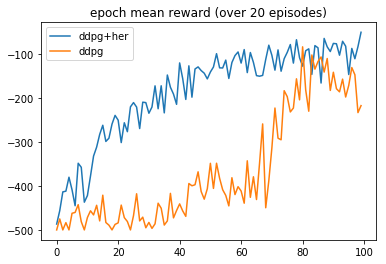

In [20]:
plt.plot(ep_mean_r, label="ddpg+her")
plt.plot(ep_mean_r_without_her, label="ddpg")
plt.legend()
plt.title("epoch mean reward (over 20 episodes)")
plt.show()

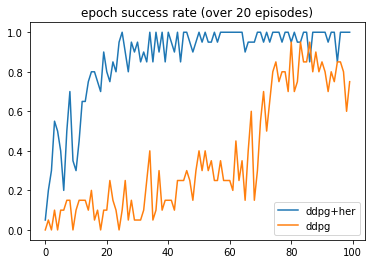

In [19]:
plt.plot(success_rate, label="ddpg+her")
plt.plot(success_rate_without_her, label="ddpg")
plt.legend()
plt.title("epoch success rate (over 20 episodes)")
plt.show()

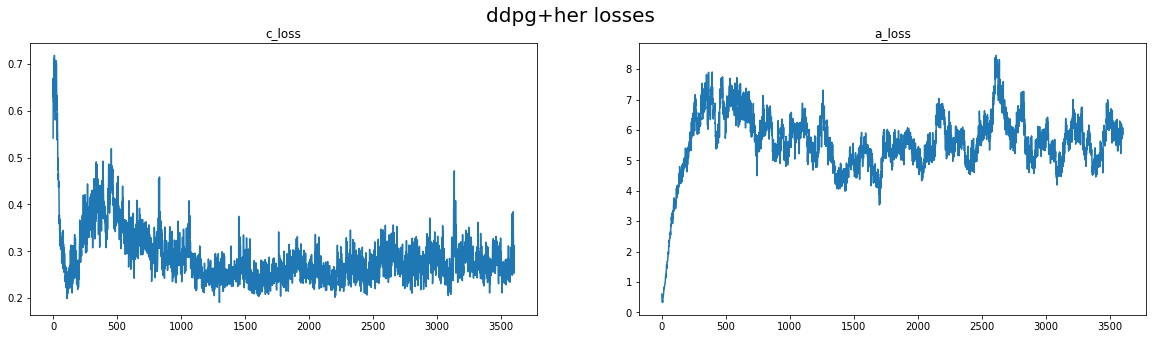

In [24]:
plt.subplots(figsize=(20,5))
plt.suptitle('ddpg+her losses', size=20)
plt.subplot(121)
plt.title('c_loss')
plt.plot(c_losses)
plt.subplot(122)
plt.title('a_loss')
plt.plot(a_losses)
plt.show()

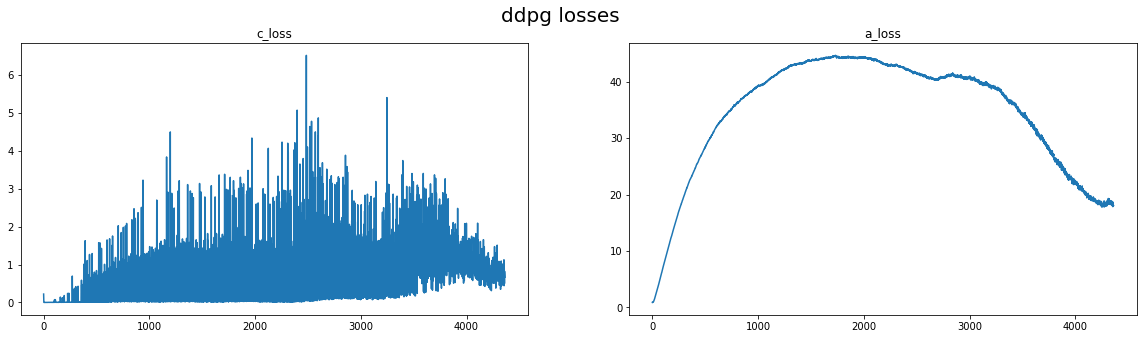

In [25]:
plt.subplots(figsize=(20,5))
plt.suptitle('ddpg losses', size=20)
plt.subplot(121)
plt.title('c_loss')
plt.plot(c_losses_without_her)
plt.subplot(122)
plt.title('a_loss')
plt.plot(a_losses_without_her)
plt.show()

In [30]:
env.close()